# Energy Dependent Gaussian Morphology



## Context

Understand the performance of classical (1D region counts extraction, and ring background) and 3D likelihood analysis for an energy dependent morphology.

- reconstructed flux, index and size

## Proposed approach:

- Simulate a custom gaussian model with $ \sigma(E) = \sigma_0 E^{-\alpha}$
- Fit with the same model (check if parameters are well reconstructed)
- Fit with a standard gaussian (2D * 1D)
- Use a RingBackground
- Extract counts from a region (approximates the 1D analysis case?)

## Imports and versions

In [1]:
%matplotlib inline
import gammapy
gammapy.__version__

'0.20.dev22+g967b81154'

In [2]:
import numpy as np
import astropy.units as u
import scipy
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.table import Table
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, DataStore
from gammapy.datasets import MapDataset
from regions import CircleSkyRegion
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator
from plot_fn import *

## Simulation

In [3]:
# Loading IRFs - one typical HESS IRF 
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs = datastore.obs(23523)
irfs = {'aeff': obs.aeff,
         'psf': obs.psf,
        'edisp': obs.edisp,
        'bkg': obs.bkg
       }

No HDU found matching: OBS_ID = 23523, HDU_TYPE = rad_max, HDU_CLASS = None


In [4]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 200 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [5]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_energy_bounds(energy_min=0.5*u.TeV, 
                                         energy_max=20*u.TeV,
                                        nbin=5, per_decade=True, name='energy')
geom = WcsGeom.create(
    skydir=pointing,
    binsz=0.02,
    width=(6, 7),
    frame="galactic",
    axes=[energy_reco],
)
energy_true = MapAxis.from_energy_bounds(energy_min=100*u.GeV, 
                                         energy_max=100*u.TeV,
                                        nbin=10, per_decade=True, name='energy_true')
empty = MapDataset.create(geom, name="dataset-simu", energy_axis_true=energy_true)

In [6]:
from gammapy.modeling.models import SpatialModel
from astropy.coordinates.angle_utilities import angular_separation
from gammapy.modeling import Parameter, Parameters


class EneDepGaussianModel(SpatialModel):
    

    tag = "EneDepGaussianModel"
    lon_0 = Parameter("lon_0", "0 deg")
    lat_0 = Parameter("lat_0", "0 deg", min=-90, max=90)
    alpha = Parameter("alpha", 0.5) #energy dependence of sigma
    ref = Parameter("ref", "1 TeV", frozen=True)
    sigma_ref = Parameter("sigma_ref", "1.0 deg", min=0) #sigma at reference value
    
    is_energy_dependent = True
    

    @staticmethod
    def get_sigma(energy, alpha, ref, sigma_ref):
        """Get the sigma for a particular energy"""
        sigma = sigma_ref * np.power(energy/ref, -alpha)
        return sigma

    def evaluate(
        self, lon, lat, energy, lon_0, lat_0, alpha, ref, sigma_ref,
    ):
        """Evaluate custom Gaussian model"""

        sigma = self.get_sigma(energy, alpha.value, ref, sigma_ref)
        sep = angular_separation(lon, lat, lon_0, lat_0)

        exponent = -0.5 * (sep / sigma) ** 2
        norm = 1 / (2 * np.pi * sigma ** 2)
        return norm * np.exp(exponent)

    @property
    def evaluation_radius(self):
        """Evaluation radius (`~astropy.coordinates.Angle`)."""
        return 5.0 * self.sigma_ref.quantity

In [7]:
# Define sky model to used simulate the data.

spatial_model = EneDepGaussianModel(frame="galactic")
spectral_model = PowerLawSpectralModel(
    index=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)

model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
bkg_model.parameters["tilt"].frozen=False

models_simu = Models([model_simu, bkg_model])
print(models_simu)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : EneDepGaussianModel
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :      0.000   +/-    0.00 deg         
    lat_0                         :      0.000   +/-    0.00 deg         
    alpha                         :      0.500   +/-    0.00             
    ref                   (frozen):      1.000       TeV         
    sigma_ref                     :      1.000   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawN

In [8]:
models_simu.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,int64,float64,float64,bool,str1
spectral,index,2.0000e+00,,0.000e+00,nan,nan,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
spatial,lon_0,0.0000e+00,deg,0.000e+00,nan,nan,False,
spatial,lat_0,0.0000e+00,deg,0.000e+00,-9.000e+01,9.000e+01,False,
spatial,alpha,5.0000e-01,,0.000e+00,nan,nan,False,
spatial,ref,1.0000e+00,TeV,0.000e+00,nan,nan,True,
spatial,sigma_ref,1.0000e+00,deg,0.000e+00,0.000e+00,nan,False,
spectral,norm,1.0000e+00,,0.000e+00,nan,nan,False,


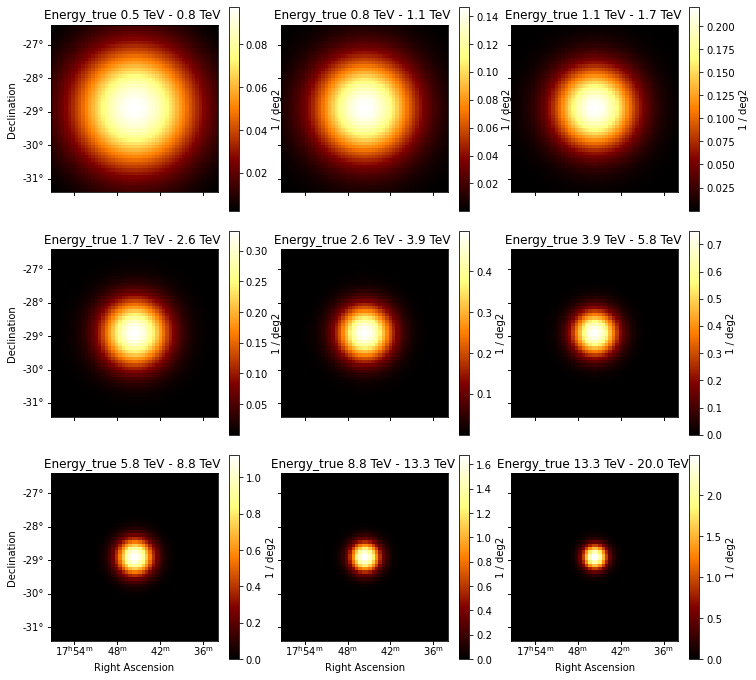

In [9]:
energy_axis = MapAxis.from_energy_bounds(
    energy_min=0.5 * u.TeV, energy_max=20.0 * u.TeV, nbin=9, name="energy_true"
)
geom_plot = WcsGeom.create(
    skydir=pointing, width=5.0 * u.deg, binsz=0.1, axes=[energy_axis]
)
spatial_model.plot_grid(geom=geom_plot, add_cbar=True);

In [10]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51552.33
	duration          : 720000.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [11]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=2.3 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)

In [12]:
# Add the model on the dataset and Poission fluctuate
dataset.models = models_simu
dataset.fake()

In [13]:
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 1721760 
  Total background counts         : 1718176.87
  Total excess counts             : 3583.13

  Predicted counts                : 1721236.98
  Predicted background counts     : 1718176.87
  Predicted excess counts         : 3060.11

  Exposure min                    : 3.83e+04 m2 s
  Exposure max                    : 5.03e+11 m2 s

  Number of total bins            : 945000 
  Number of fit bins              : 374076 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -3226541.97

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : EneDepGaussianModel
    Temporal model type       : 
    Par

The datset has been simultaed. Now look at the excess maps.Setting models to none to imply what would be be seen after the data reduction case

In [14]:
dataset.models = None

No handles with labels found to put in legend.


 : mu = 0.35, std = 0.96


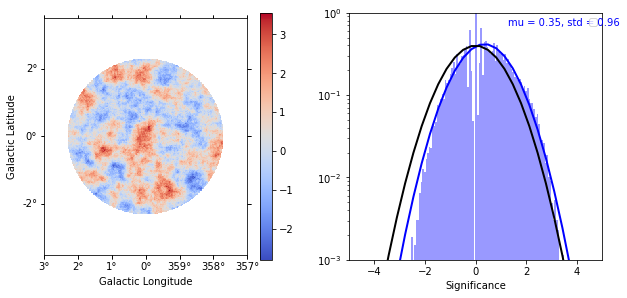

In [15]:

estimator = ExcessMapEstimator(correlation_radius=0.3*u.deg)
res1 = estimator.run(dataset)
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=res1['sqrt_ts'].geom.wcs)
ax2 = plt.subplot(222)
res1['sqrt_ts'].plot(add_cbar=True, cmap='coolwarm', ax=ax1)


plot_hist(res1['sqrt_ts'], ax=ax2)

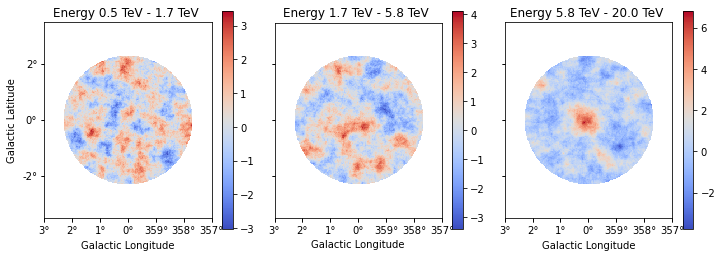

In [16]:
estimator = ExcessMapEstimator(correlation_radius=0.3*u.deg, 
                               energy_edges=energy_reco.downsample(3).edges)
res1 = estimator.run(dataset)
res1['sqrt_ts'].plot_grid(add_cbar=True, cmap='coolwarm');

Interesting to note that no clear morphology evolution is expected from significance maps at different energies.

In [17]:
dataset1 = dataset.copy(name='dataset1')
dataset2 = dataset.copy(name='dataset2')

## Fitting


### 1. With same model for sanity

In [18]:
bkg0 = FoVBackgroundModel(dataset_name=dataset1.name)
models0 = Models([bkg0])
dataset1.models = models0

In [19]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset1])

CPU times: user 186 ms, sys: 17.2 ms, total: 203 ms
Wall time: 187 ms


In [20]:
TS0 = dataset1.stat_sum()

In [21]:
spatial_model0 = EneDepGaussianModel(frame="galactic")
spectral_model0 = PowerLawSpectralModel(
    index=3, amplitude="8e-13 cm-2 s-1 TeV-1", reference="1 TeV"
)

model_enedep = SkyModel(
    spatial_model=spatial_model0,
    spectral_model=spectral_model0,
    name="model-fit",
)
model_enedep.parameters["lon_0"].min = -2.0
model_enedep.parameters["lon_0"].max = 2.0
model_enedep.parameters["lat_0"].min = -2.0
model_enedep.parameters["lat_0"].max = 2.0


In [22]:
models0.append(model_enedep)
dataset1.models = models0

In [23]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset1])

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00206309 is smaller than machine limit 0.192317 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.00206309 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W VariableMetricBuilder No convergence; Edm 0.0264622 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W VariableMetricBuilder No convergence; Edm 0.0264622 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W VariableMetricBuilder No convergence; Edm 0.0264622 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W Va

In [24]:
TS1 = dataset1.stat_sum()
print('detection TS: ',(TS0-TS1))

detection TS:  53.032704644370824


In [25]:
models0.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str12,str8,str9,float64,str14,float64,float64,float64,bool,str1
dataset1-bkg,spectral,norm,1.0008e+00,,8.940e-04,nan,nan,False,
dataset1-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
dataset1-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
model-fit,spectral,index,1.8089e+00,,1.513e-01,nan,nan,False,
model-fit,spectral,amplitude,6.2190e-13,cm-2 s-1 TeV-1,2.748e-13,nan,nan,False,
model-fit,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
model-fit,spatial,lon_0,6.3813e-02,deg,6.104e-02,-2.000e+00,2.000e+00,False,
model-fit,spatial,lat_0,-1.8442e-02,deg,5.994e-02,-2.000e+00,2.000e+00,False,
model-fit,spatial,alpha,6.2419e-01,,1.785e-01,nan,nan,False,


No handles with labels found to put in legend.


 : mu = 0.03, std = 0.95


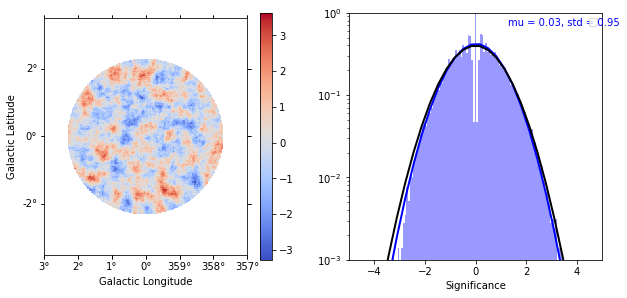

In [26]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=res1['sqrt_ts'].geom.wcs)
ax2 = plt.subplot(222)

estimator = ExcessMapEstimator(correlation_radius=0.2*u.deg)
res1 = estimator.run(dataset1)
res1['sqrt_ts'].plot(add_cbar=True, cmap='coolwarm', ax=ax1)

plot_hist(res1['sqrt_ts'], ax=ax2)

array([<WCSAxesSubplot:title={'center':'Energy 0.5 TeV - 1.1 TeV '}, xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
       <WCSAxesSubplot:title={'center':'Energy 1.1 TeV - 5.8 TeV '}, xlabel='Galactic Longitude'>,
       <WCSAxesSubplot:title={'center':'Energy 5.8 TeV - 20.0 TeV '}, xlabel='Galactic Longitude'>],
      dtype=object)

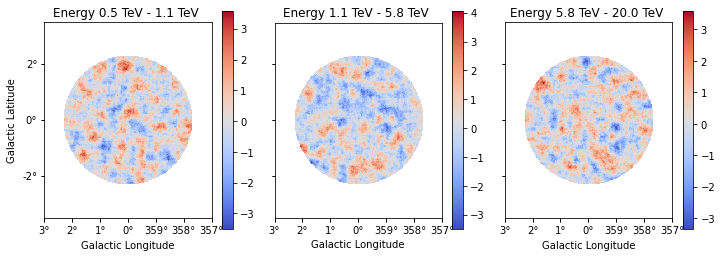

In [27]:
estimator = ExcessMapEstimator(correlation_radius=0.2*u.deg, energy_edges=[0.5, 1, 5, 20]*u.TeV)
res1 = estimator.run(dataset1)
res1['sqrt_ts'].plot_grid(add_cbar=True, cmap='coolwarm')

In [28]:
table = Table(names=["parameter", "simulated", "reconstructed", "error"],
             dtype=('U1', 'f8','f8','f8'))
for p1, p2 in zip(model_simu.parameters, model_enedep.parameters):
    table.add_row([p1.name, p1.quantity, p2.quantity, p2.error])
table

parameter,simulated,reconstructed,error
str9,float64,float64,float64
index,2.0,1.8088879502525403,0.15131296333769823
amplitude,1e-12,6.218970524989029e-13,2.7482697710082673e-13
reference,1.0,1.0,0.0
lon_0,0.0,0.06381336273472617,0.06103788851488782
lat_0,0.0,-0.01844188035284898,0.05994247039167786
alpha,0.5,0.6241905796759495,0.17845284253763832
ref,1.0,1.0,0.0
sigma_ref,1.0,1.2052272531672688,0.4331627135155886


In [29]:
size_simulated = model_simu.spatial_model.get_sigma(energy=energy_reco.edges,
                                                   alpha=model_simu.parameters["alpha"].quantity,
                                                   ref=model_simu.parameters["ref"].quantity,
                                                   sigma_ref=model_simu.parameters["sigma_ref"].quantity)
simulated_size_lowest_bin= size_simulated[0]
print("simulated sizes in each bin", size_simulated)

simulated sizes in each bin [1.41421356 1.15215701 0.93866005 0.76472449 0.62301954 0.50757279
 0.41351855 0.33689275 0.27446586 0.2236068 ] deg


In [30]:
size_fit_enedep = model_enedep.spatial_model.get_sigma(energy=energy_reco.edges,
                                                   alpha=model_enedep.parameters["alpha"].quantity,
                                                   ref=model_enedep.parameters["ref"].quantity,
                                                   sigma_ref=model_enedep.parameters["sigma_ref"].quantity)
fitted_size_lowest_bin= size_fit_enedep[0]
print("fitted sizes in each bin", size_fit_enedep)

fitted sizes in each bin [1.85767198 1.43833135 1.11365036 0.86226107 0.66761901 0.51691438
 0.40022898 0.30988349 0.2399321  0.18577115] deg


### 2. Standard Gaussian * PowerLaw

In [31]:
dataset1.models = None

In [32]:
bkg1 = FoVBackgroundModel(dataset_name=dataset1.name)
models1 = Models([bkg1])
dataset1.models = models1

In [33]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset1])

CPU times: user 207 ms, sys: 11.7 ms, total: 219 ms
Wall time: 165 ms


In [34]:
TS2 = dataset1.stat_sum()

In [35]:
result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str3,float64,float64,float64,bool,str1
spectral,norm,1.0021e+00,,7.637e-04,nan,nan,False,
spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,


In [36]:
spatial1 = GaussianSpatialModel(frame='galactic')
spectral1 = PowerLawSpectralModel()
sky_model1 = SkyModel(spatial_model=spatial1, 
                      spectral_model=spectral1, name='sky1')

models1.append(sky_model1)
dataset1.models = models1 

In [37]:
spatial1.parameters['lon_0'].value = 0.0
spatial1.parameters['lat_0'].value = 0.0
spatial1.parameters['sigma'].value = 0.2

spatial1.parameters["lon_0"].min = -2.0
spatial1.parameters["lon_0"].max = 2.0
spatial1.parameters["lat_0"].min = -2.0
spatial1.parameters["lat_0"].max = 2.0

In [38]:
dataset1.models.names

['dataset1-bkg', 'sky1']

In [39]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset1])

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0240623 is smaller than machine limit 0.192317 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.0240623 is above tolerance 0.002
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def., try to make pos.def.
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -5.42914e-05
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -0.00434727
W MnPosDef Added to diagonal of Error matrix a value 0.504348
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 1.1582 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0

In [40]:
TS3 = dataset1.stat_sum()
print('detection TS: ',(TS2-TS3))

detection TS:  52.340535059571266


In [41]:
print('del L over 3D model: ',(TS1-TS3))

del L over 3D model:  -0.6921695847995579


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

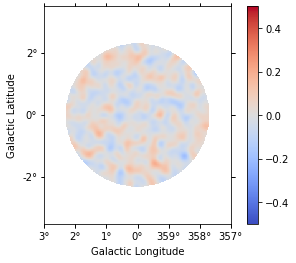

In [42]:
dataset1.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)

In [43]:
models1.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str12,str8,str9,float64,str14,float64,float64,float64,bool,str1
dataset1-bkg,spectral,norm,1.0014e+00,,7.833e-04,nan,nan,False,
dataset1-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
dataset1-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
sky1,spectral,index,1.2827e+00,,1.443e-01,nan,nan,False,
sky1,spectral,amplitude,1.5934e-13,cm-2 s-1 TeV-1,6.397e-14,nan,nan,False,
sky1,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
sky1,spatial,lon_0,4.8182e-02,deg,5.754e-02,-2.000e+00,2.000e+00,False,
sky1,spatial,lat_0,-5.2476e-02,deg,5.508e-02,-2.000e+00,2.000e+00,False,
sky1,spatial,sigma,2.5497e-01,deg,3.947e-02,0.000e+00,nan,False,


In [44]:
print("3D fit index: ", models1.parameters["index"].value, "\pm", models1.parameters["index"].error)
print("3D fit size: ", models1.parameters["sigma"].value, "\pm", models1.parameters["sigma"].error)

3D fit index:  1.282749939607087 \pm 0.144302649028439
3D fit size:  0.2549700497049199 \pm 0.0394706558578123


No handles with labels found to put in legend.


 : mu = 0.03, std = 0.93


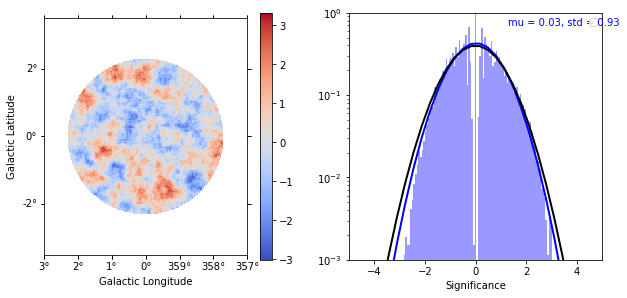

In [45]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=res1['sqrt_ts'].geom.wcs)
ax2 = plt.subplot(222)

estimator = ExcessMapEstimator(correlation_radius=0.3*u.deg)
res1 = estimator.run(dataset1)
res1['sqrt_ts'].plot(add_cbar=True, cmap='coolwarm', ax=ax1)

plot_hist(res1['sqrt_ts'], ax=ax2)

Looking at the likelihood and the significance maps, no apriori reason to assume an energy dependece. However, we **mis-reconstruct** the index and size of the source.

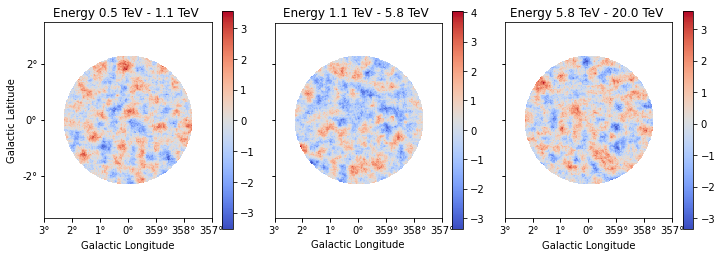

In [46]:
estimator = ExcessMapEstimator(correlation_radius=0.2*u.deg, energy_edges=[0.5, 1, 5, 20]*u.TeV)
res1 = estimator.run(dataset1)
res1['sqrt_ts'].plot_grid(add_cbar=True, cmap='coolwarm');

## RingBackground

In [47]:
dataset3=dataset.copy()
dataset3.models=None

In [48]:
from gammapy.datasets import MapDatasetOnOff
from gammapy.makers import RingBackgroundMaker

In [49]:
energy_axis = dataset3.counts.geom.axes["energy"]
geom_image = geom.to_image().to_cube([energy_axis.squash()])

# Make the exclusion mask
regions = CircleSkyRegion(center=pointing, radius=0.4 * u.deg)
exclusion_mask = ~geom_image.region_mask([regions])

In [50]:
ring_maker = RingBackgroundMaker(
    r_in="1.0 deg", width="0.3 deg", exclusion_mask=exclusion_mask
)
dataset_on_off = ring_maker.run(dataset3.to_image())

/Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ASinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:209: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


 : mu = 0.08, std = 0.99
 : mu = 0.04, std = 0.96


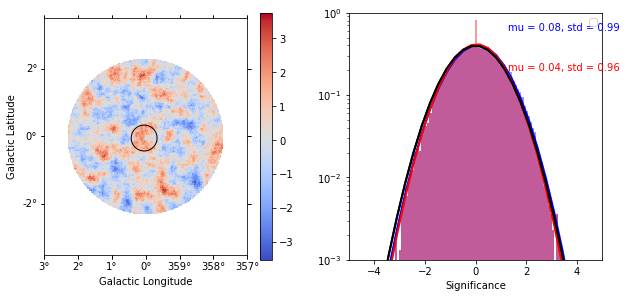

In [51]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=res1['sqrt_ts'].geom.wcs)
ax2 = plt.subplot(222)

estimator = ExcessMapEstimator(correlation_radius=0.2*u.deg)
res1 = estimator.run(dataset_on_off)
res1['sqrt_ts'].plot(add_cbar=True, cmap='coolwarm', ax=ax1)
models1.plot_regions(ax=ax1, color="black")

plot_hist(res1['sqrt_ts'], ax=ax2, label_pos=0.6)
plot_hist(res1['sqrt_ts']*exclusion_mask, ax=ax2, label_pos=0.2, color="red")


## Fit spectrum in an on-region
- Does this mimic the reflected ?

In [52]:
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff

In [53]:
def fit_different_on(radius=[]):
    results = []
    for r in radius:
        on_region = CircleSkyRegion(center=SkyCoord(0,0, unit='deg', frame='galactic'),
                           radius=r)
        dataset_spectrum = dataset2.to_spectrum_dataset(on_region=on_region)  
        spectral2 = PowerLawSpectralModel()
        sky_model2 = SkyModel(spectral_model=spectral2)
        dataset_spectrum.models = sky_model2
        fit = Fit(optimize_opts={"print_level": 0})
        result = fit.run(datasets=[dataset_spectrum])
        results.append(result)
    return results

In [54]:
radius = np.linspace(0.1, 2, 10)
radius = radius*u.deg
print(radius)

[0.1        0.31111111 0.52222222 0.73333333 0.94444444 1.15555556
 1.36666667 1.57777778 1.78888889 2.        ] deg


In [55]:
%%time
results = fit_different_on(radius)

/Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages

CPU times: user 4.35 s, sys: 64.9 ms, total: 4.42 s
Wall time: 4.4 s


/Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [56]:
size_simulated = model_simu.spatial_model.get_sigma(energy=energy_reco.edges,
                                                   alpha=model_simu.parameters["alpha"].quantity,
                                                   ref=model_simu.parameters["ref"].quantity,
                                                   sigma_ref=model_simu.parameters["sigma_ref"].quantity)
simulated_size_lowest_bin= size_simulated[0]
print("simulated sizes in each bin", size_simulated)

simulated sizes in each bin [1.41421356 1.15215701 0.93866005 0.76472449 0.62301954 0.50757279
 0.41351855 0.33689275 0.27446586 0.2236068 ] deg


In [57]:
index = []
index_err =[]
amplitude = []
amplitude_err = []
stat = []
for aresult in results:
    index.append(aresult.parameters['index'].value)
    index_err.append(aresult.parameters['index'].error)
    amplitude.append(aresult.parameters['amplitude'].value)
    amplitude_err.append(aresult.parameters['amplitude'].error)
    stat.append(aresult.total_stat)

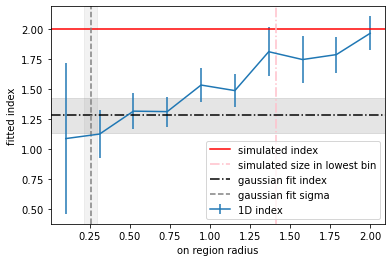

In [58]:
plt.errorbar(x=radius.value, y=index, yerr=index_err, label="1D index")
plt.axhline(model_simu.parameters['index'].value, color='red',
           label="simulated index")
plt.axvline(simulated_size_lowest_bin.value, color='pink', ls="-.",
            label="simulated size in lowest bin")

plt.axhspan(spectral1.parameters['index'].value - spectral1.parameters['index'].error,
            spectral1.parameters['index'].value + spectral1.parameters['index'].error,
            color='black', alpha=0.1)
plt.axhline(spectral1.parameters['index'].value, color='black',
            ls='-.', label="gaussian fit index")

plt.axvspan(spatial1.parameters['sigma'].value - spatial1.parameters['sigma'].error,
            spatial1.parameters['sigma'].value + spatial1.parameters['sigma'].error,
            color='grey', alpha=0.1)
plt.axvline(spatial1.parameters['sigma'].value, color='grey', ls='--',
           label="gaussian fit sigma")
plt.xlabel("on region radius")
plt.ylabel("fitted index")
plt.legend()

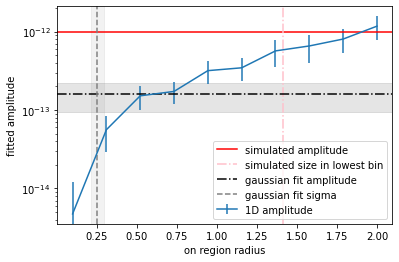

In [59]:
plt.errorbar(x=radius.value, y=amplitude, yerr=amplitude_err, label="1D amplitude")


plt.axhline(model_simu.parameters['amplitude'].value, color='red', 
            label="simulated amplitude")

plt.axvline(simulated_size_lowest_bin.value, color='pink', ls="-.",
            label="simulated size in lowest bin")

plt.axhspan(spectral1.parameters['amplitude'].value - spectral1.parameters['amplitude'].error,
            spectral1.parameters['amplitude'].value + spectral1.parameters['amplitude'].error,
            color='black', alpha=0.1)
plt.axhline(spectral1.parameters['amplitude'].value, color='black',ls='-.',
           label="gaussian fit amplitude")

plt.axvspan(spatial1.parameters['sigma'].value - spatial1.parameters['sigma'].error,
            spatial1.parameters['sigma'].value + spatial1.parameters['sigma'].error,
            color='grey', alpha=0.1)
plt.axvline(spatial1.parameters['sigma'].value, color='grey', ls='--',
           label="gaussian fit sigma")
plt.xlabel("on region radius")
plt.ylabel("fitted amplitude")
plt.yscale("log")

plt.legend()

## Conclusion

- The standard 3D likelihood method with a standard Gaussian model reconstructs a much smaller size, harder index and lesser flux than simulated
- The reconstructed size depends upon the energy dependence of the morphology
- Reconstruct an *incorrect* index and size, so we need to be careful. This is not bovious from looking at the TS maps or the fit diagnostics
--

- The ring background performance depends upon the ring size and exclusion regions. A strong possibility to miss the source

--

- A 1D region based analysis can work ok for certain sizes
- for small regions: harder index
- For large region: consistent index but larger flux

--

- Spectral parameters differ between 3D and 1D analysis

Sanity check with `alpha = 0` gives expected results